In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# MAKE DATASET

In [2]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
import gc
import math
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from smart_open import open
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from keras.layers import Dropout
from matplotlib import pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install --upgrade tensorflow


In [4]:
dev_location = "dev_data"
test_location = "test_data"
train_location = "train_data"

devData = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/dev_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
testData = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/full_test_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
trainData = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/train_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]

dataset = np.concatenate((devData, np.concatenate((testData, trainData))))


In [5]:
# print(dataset)
gc.collect()
max_num_words = 17
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)
stop_words = set(stopwords.words('english'))

In [6]:
def checkDataPointExistence(patientID, split):
  for i in split:
    if(patientID == i[0]):
      return True
  return False

In [7]:
def getData(patientID, location):
  print("PatientID: " + str(int(patientID)))
  retData = [int(patientID)]
  textD = getTextData(patientID, location)
  textD = np.array(textD)
  audioD = getAudioData(patientID, location, textD)
  videoD = getVideoData(str(int(patientID)), location, textD)
  # patientD = np.concatenate((textD, audioD, videoD), axis = 1)
  # print("Final Patient Data: " + str(patientD.shape))
  # patientD = textD

  return textD,audioD,videoD

In [8]:
def getTextData(patientID, location):
  fileName = "/content/drive/MyDrive/Dataset_Extracted/"+ str(location) + "/" + str(int(patientID)) + "_TRANSCRIPT.csv"
  file = np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))
  outputList = []

  for i in range(len(file)):
    sentence = file[i][3]
    words = str(sentence).split(" ")
    totalWordLength = 0
    for word in words:
      totalWordLength += len(word)

    sentenceStart = file[i][0]
    sentenceEnd = file[i][1]
    speaker = file[i][2]
    if speaker == 'Ellie':
      continue
    else:
      speaker = 1

    totalTime = sentenceEnd - sentenceStart
    timePerChar = totalTime/totalWordLength

    wordStart = sentenceStart
    for word in words:
      wordEnd = wordStart + (timePerChar * len(word))
      appender = [wordStart, wordEnd, speaker]
      vector = list(returnWordToVec(word))
      for v in vector:
        appender.append(v)
      # print(appender)
      # print(len(appender))
      outputList.append(appender)
      wordStart = wordEnd

  return outputList

In [9]:
def remove_StopWords(sentence):
    filtered_sentence = []
    for w in sentence:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence


In [10]:
def returnWordToVec(word):
  word = str(word)
  try:
    if word[0] == '<':
        word = word[1:]
    if word[-1] == '>':
        word = word[0:-1]
  except:
    dfdsd = 3
  if(word in model):
      return np.array(model[word])
  else:
    return np.zeros((300))

In [11]:
def audioDataHelper(X):
    for i in range(X.shape[0]):
        if(X[i,1] == 0):
            X[i,0] = 0
            for j in range(7):
                X[i,j+1] = 0
    X = np.array(X)
    return X

In [12]:
def getAudioData(patientID, location, textD):
  fileName = "/content/drive/MyDrive/Dataset_Extracted/"+ str(location) + "/" + str(int(patientID)) + "_COVAREP.csv"
  data = pd.read_csv(fileName,header = None)
  data = data.iloc[:,:].values
  data = audioDataHelper(data)
  # print("Audio Raw Data:" + str(data.shape))
  sentenceDatas = []
  for sentence in textD:
    sentenceStartime = sentence[0]
    sentenceEndTime = sentence[1]
    startIndex = math.floor(sentenceStartime/0.01)
    endIndex = math.ceil(sentenceEndTime/0.01)
    sentenceData = data[startIndex: endIndex]
    sentenceData = np.average(sentenceData, axis = 0)
    sentenceData = np.array(sentenceData.reshape(1, -1))
    sentenceDatas.append(sentenceData)

  sentenceDatas = np.array(sentenceDatas)
  sentenceDatas = np.reshape(sentenceDatas, (textD.shape[0],-1))
  # print("Audio Final Data:" + str(sentenceDatas.shape))

  return sentenceDatas

In [13]:
def getVideoDataHelper(patientID, location):
  root = "/content/drive/MyDrive/Dataset_Extracted/"+ str(location) + "/"
  file1 = root + (patientID)+"_CLNF_AUs.txt"
  file2 = root + (patientID)+"_CLNF_features.txt"
  file3 = root + (patientID)+"_CLNF_features3D.txt"
  file4 = root + (patientID)+"_CLNF_gaze.txt"
  # file5 = root + (patientID)+"_CLNF_hog.bin"
  file6 = root + (patientID)+"_CLNF_pose.txt"
  data = processVideoData(file1)
  data = np.concatenate((data, processVideoData(file2)), 1)
  data = np.concatenate((data, processVideoData(file3)), 1)
  data = np.concatenate((data, processVideoData(file4)), 1)
  data = np.concatenate((data, processVideoData(file6)), 1)


  # try:
  #   hogFile = open(file5, 'r')
  # except:
  #   print("Hog tXT file")
  #   hogFile = open(root + (patientID)+"_CLNF_hog.txt", 'r')
  # hogData = np.fromfile(hogFile, dtype = np.uint32)
  # hogData = np.reshape(hogData, (-1, 4468))

  # data = np.concatenate((data, hogData), 1)
  return data

In [14]:
def processVideoData(filename):
  try:
    data = pd.read_csv(filename,delimiter=',', dtype=float)
    X = data.iloc[:,:].values
    X = np.delete(X, 0, 1)
    X = np.delete(X, 1, 1)
  except:
    print("Video Data corrupt, fixing.")
    data = pd.read_csv(filename,delimiter=',')
    X = data.iloc[:,:].values
    X = np.delete(X, 0, 1)
    X = np.delete(X, 1, 1)
    for i in range(len(X)):
        if(isinstance(X[i][5],str) or isinstance(X[i][7],str)):
            X[i] = np.zeros((1, X.shape[1]))
            # print("se" , end = " ")
  return X


In [15]:
def getVideoData(patientID, location, textD):
  data = getVideoDataHelper(patientID, location)
  sentenceDatas = []
  for sentence in textD:
    sentenceStartime = sentence[0]
    sentenceEndTime = sentence[1]
    startIndex = math.floor(sentenceStartime/0.333)
    endIndex = math.ceil(sentenceEndTime/0.333)
    # print("Start Time: " + str(startIndex))
    sentenceData = data[startIndex: endIndex]
    sentenceData = np.average(sentenceData, axis = 0)
    # This might be a possible error
    sentenceData = np.array(sentenceData.reshape(1, -1))
    sentenceDatas.append(sentenceData)

  sentenceDatas = np.array(sentenceDatas)
  sentenceDatas = np.reshape(sentenceDatas, (textD.shape[0],-1))
  # print("Video Final Data:" + str(sentenceDatas.shape))
  return sentenceDatas

In [16]:
# Xtrain = []
Ytrain = []
# Xtest = []
Ytest = []


audio_train = []
video_train = []
text_train = []

audio_test = []
video_test = []
text_test = []


lengths = []

In [17]:
for datapoint in dataset:
  # print(datapoint[0])
  if(checkDataPointExistence(datapoint[0], devData)):

    #Data Point in Dev Set
    text,audio,video = getData(datapoint[0], dev_location)
    text = text[:,2:]
    audio_train.append(audio)
    video_train.append(video)
    text_train.append(text)
    Ytrain.append(datapoint[1])
    #print(data)
  if(checkDataPointExistence(datapoint[0], testData)):
    # Data Point in Test Set
    text,audio,video = getData(datapoint[0], test_location)
    text = text[:,2:]
    audio_test.append(audio)
    video_test.append(video)
    text_test.append(text)
    Ytest.append(datapoint[1])
  elif(checkDataPointExistence(datapoint[0], trainData)):
    # Data Point in Train Set
    text,audio,video = getData(datapoint[0], train_location)
    text = text[:,2:]
    audio_train.append(audio)
    video_train.append(video)
    text_train.append(text)
    Ytrain.append(datapoint[1])
  # lengths.append(data.shape[0])
model = []
gc.collect()


PatientID: 302


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 307


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 331


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 335


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 346


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 367
Video Data corrupt, fixing.


<ipython-input-14-15022e817309>:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename,delimiter=',')


Video Data corrupt, fixing.


<ipython-input-14-15022e817309>:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename,delimiter=',')


Video Data corrupt, fixing.
PatientID: 377
PatientID: 381
PatientID: 382
PatientID: 388
PatientID: 389
PatientID: 390
PatientID: 395
PatientID: 403
PatientID: 404


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 406


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 413
PatientID: 417
PatientID: 418
PatientID: 420
PatientID: 422
PatientID: 436
PatientID: 439
PatientID: 440
PatientID: 451
PatientID: 458
PatientID: 472
PatientID: 476
PatientID: 477
PatientID: 482
PatientID: 483
PatientID: 484


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 489
PatientID: 490
PatientID: 492
PatientID: 300
PatientID: 301
PatientID: 306
PatientID: 308
PatientID: 309


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 311
PatientID: 314


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 323


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 329


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 332


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 334


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 337


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 349


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 354


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 359


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 361


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 365
PatientID: 373
PatientID: 378
PatientID: 384
PatientID: 387
PatientID: 396
Video Data corrupt, fixing.


<ipython-input-14-15022e817309>:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename,delimiter=',')


Video Data corrupt, fixing.


<ipython-input-14-15022e817309>:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename,delimiter=',')


Video Data corrupt, fixing.
PatientID: 399
PatientID: 405


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 407
PatientID: 408
PatientID: 410
PatientID: 411
PatientID: 421
PatientID: 424
PatientID: 431
PatientID: 432
Video Data corrupt, fixing.


<ipython-input-14-15022e817309>:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename,delimiter=',')


Video Data corrupt, fixing.


<ipython-input-14-15022e817309>:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename,delimiter=',')


Video Data corrupt, fixing.
PatientID: 435


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 438
PatientID: 442
PatientID: 450
PatientID: 452
PatientID: 453
PatientID: 461
PatientID: 462
PatientID: 465
PatientID: 466
PatientID: 467
PatientID: 469
PatientID: 470
PatientID: 480
PatientID: 481
PatientID: 303
PatientID: 304


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 305
PatientID: 310


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 312


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 313


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 315
PatientID: 316


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 317


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 318


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 319


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 320
PatientID: 321
PatientID: 322
PatientID: 324
PatientID: 325


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 326


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 327


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 328


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 330


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 333


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 336


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 338


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 339


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 340


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 341


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 343
PatientID: 344


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 345


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 347


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 348


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 350


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 351


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 352


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 353


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 355


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 356


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 357


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 358


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 360


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 362


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 363
PatientID: 364
PatientID: 366
PatientID: 368
PatientID: 369
PatientID: 370
PatientID: 371
PatientID: 372
PatientID: 374


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 375
PatientID: 376
PatientID: 379
PatientID: 380
PatientID: 383


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 385
PatientID: 386
PatientID: 391
PatientID: 392


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 393
PatientID: 397
PatientID: 400
PatientID: 401
PatientID: 402
PatientID: 409
PatientID: 412
PatientID: 414
PatientID: 415
PatientID: 416
PatientID: 419


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 423
PatientID: 425
PatientID: 426
PatientID: 427
PatientID: 428
PatientID: 429
PatientID: 430
PatientID: 433
PatientID: 434
PatientID: 437
PatientID: 441


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 443
PatientID: 444
PatientID: 445
PatientID: 446
PatientID: 447
PatientID: 448
PatientID: 449
PatientID: 454
PatientID: 455
PatientID: 456


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 457


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


PatientID: 459
PatientID: 463
PatientID: 464
PatientID: 468
PatientID: 471
PatientID: 473
PatientID: 474
PatientID: 475
PatientID: 478
PatientID: 479
PatientID: 485
PatientID: 486
PatientID: 487
PatientID: 488
PatientID: 491


0

In [18]:
def refactor(arr, size):
  temp = arr[0:min(len(arr),size), :]
  if (len(temp) < size):
    temp = np.concatenate((temp, np.zeros(((size - len(temp)), arr.shape[1]))), axis = 0 )
  return temp


In [19]:
numberOfSentences = 1700

for i in range(len(audio_train)):
  # Xtrain[i] = refactor(Xtrain[i], numberOfSentences)
  audio_train[i] = refactor(audio_train[i], numberOfSentences)
  video_train[i] = refactor(video_train[i], numberOfSentences)
  text_train[i] = refactor(text_train[i], numberOfSentences)
  # print(Xtrain[i].shape)


In [20]:
for i in range(len(audio_test)):
  audio_test[i] = refactor(audio_train[i], numberOfSentences)
  video_test[i] = refactor(video_train[i], numberOfSentences)
  text_test[i] = refactor(text_train[i], numberOfSentences)
  # print(Xtest[i].shape)

audio_test = np.array(audio_test)
video_test = np.array(video_test)
text_test = np.array(text_test)
# text_test = text_test[:,:,2:]

audio_train = np.array(audio_train)
video_train = np.array(video_train)
text_train = np.array(text_train)
# dataset = []
gc.collect()

print(audio_test.shape,video_test.shape,text_test.shape)
print(audio_train.shape,video_train.shape,text_train.shape)


(47, 1700, 74) (47, 1700, 388) (47, 1700, 301)
(142, 1700, 74) (142, 1700, 388) (142, 1700, 301)


In [21]:
dataset = []
devData = []
trainData = []
testdata = []
gc.collect()

Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

gc.collect()


0

In [22]:
import sklearn
from sklearn import preprocessing

def upsample(X_train,Y_train):
  X_train_0 = X_train[Y_train==0]
  X_train_1 = X_train[Y_train==1]

  Y_train_1 = Y_train[Y_train==1]
  # print(Y_train_1.shape)
  # print(X_train_1.shape)
  size = X_train_0.shape[0] - X_train_1.shape[0]
  X = []
  Y = []
  X_train = list(X_train)
  Y_train = list(Y_train)
  while(size>0):
    size -= 1
    index = np.random.randint(0,X_train_1.shape[0]-1)
    leave_index = np.random.randint(0,len(X_train)-1)
    X_add = X_train_1[index]
    X_leave = X_train[leave_index]

    Y_add = Y_train_1[index]
    Y_leave = Y_train[leave_index]

    X_train[leave_index] = X_add
    X_train.append(X_leave)

    Y_train[leave_index] = Y_add
    Y_train.append(Y_leave)


  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  return X_train,Y_train

In [23]:
print(video_train.dtype)

object


In [24]:
video_train = video_train.astype(np.float32)

In [25]:
video_train = np.nan_to_num(video_train)


In [26]:
audio_train = np.nan_to_num(audio_train)
video_train = np.nan_to_num(video_train)
text_train = np.nan_to_num(text_train)


audio_train, _ = upsample(audio_train,Ytrain)
video_train, _ = upsample(video_train,Ytrain)
text_train, Ytrain = upsample(text_train,Ytrain)

gc.collect()

0

In [27]:
for i in range(audio_train.shape[0]):
  audio_train[i] = sklearn.preprocessing.normalize(audio_train[i])
  video_train[i] = sklearn.preprocessing.normalize(video_train[i])
  text_train[i] = sklearn.preprocessing.normalize(text_train[i])



audio_test = np.nan_to_num(audio_test)
video_test = np.nan_to_num(video_test)
text_test = np.nan_to_num(text_test)


In [28]:
for i in range(audio_test.shape[0]):
  audio_test[i] = sklearn.preprocessing.normalize(audio_test[i])
  video_test[i] = sklearn.preprocessing.normalize(video_test[i])
  text_test[i] = sklearn.preprocessing.normalize(text_test[i])

gc.collect()

0

# BILSTM MODEL WITH GATING (WORD LEVEL)

In [29]:
#Word Level

#Text+Audio+Video
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import layers

import numpy as np

class Highway(layers.Layer):

  def __init__(self):
    super(Highway, self).__init__()

  def build(self, input_shape):
    n_sentences = input_shape[1]
    n_features = input_shape[2]
    carry_bias = keras.initializers.Constant(value=-1.0)
    random_dist = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)

    carry_bias_2 = keras.initializers.Constant(value= 0.1)

    self.W_T = self.add_weight(shape=(n_features, n_features),initializer = random_dist,trainable=True)
    self.b_T = self.add_weight(shape=( n_sentences, n_features),initializer = carry_bias, trainable=True)
    # self.W_T = tf.Variable(tf.random.truncated_normal([n_data_points,n_features, n_features], stddev=0.1),trainable=True)
    # self.b_T = tf.Variable(tf.constant(-1.0, shape=[n_data_points, n_sentences, n_features]),trainable=True)

    self.W = self.add_weight(shape=( n_features, n_features),initializer = random_dist, trainable=True)
    self.b = self.add_weight(shape=( n_sentences, n_features),initializer = carry_bias_2, trainable=True)
    # self.W = tf.Variable(tf.random.truncated_normal([n_data_points,n_features, n_features], stddev=0.1), trainable=True)
    # self.b = tf.Variable(tf.constant(0.1, shape=[n_data_points, n_sentences, n_features]), trainable=True)


  def call(self, inputs):
    x = inputs
    T = tf.sigmoid(tf.matmul(x, self.W_T) + self.b_T, name="transform_gate")
    H = tf.nn.relu(tf.matmul(x, self.W) + self.b, name="activation")
    C = tf.subtract(1.0, T, name="carry_gate")

    return tf.add(tf.multiply(H, T), tf.multiply(x, C), "y")



In [30]:
# Multiple Inputs
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

# first input model
input1 = Input(shape=(1700,74), name = 'Audio_input')
highway1 = Highway()(input1)
highway5 = Highway()(highway1)
highway6 = Highway()(highway5)
dense1 = Dense(74)(highway6)

# second input model
input2 = Input(shape=(1700,388), name = 'Video_input')
highway2 = Highway()(input2)
highway3 = Highway()(highway2)
highway4 = Highway()(highway3)
# dense8 = Dense(1000)(highway4)
# dense9 = Dense(500)(dense8)
dense7 = Dense(200)(highway4)
dense2 = Dense(74)(dense7)

input3 = Input(shape = (1700,301), name = 'Text_input')
# dense4 = Dense(1000)(input3)
# dense5 = Dense(500)(dense4)
dense6 = Dense(150)(input3)
dense3 = Dense(74)(dense6)
# merge input models
merge = concatenate([dense1,dense2,dense3], axis = 1)
# interpretation model
lstm = LSTM(128, dropout = 0.2, recurrent_dropout = 0.2)
bidire = Bidirectional(lstm)
output = Dense(1, activation='sigmoid')(bidire(merge))
model = Model(inputs=[input1, input2, input3], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model)
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# inp = np.array([audio_train,video_train,text_train], dtype = object)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Video_input (InputLayer)    [(None, 1700, 388)]          0         []                            
                                                                                                  
 Audio_input (InputLayer)    [(None, 1700, 74)]           0         []                            
                                                                                                  
 highway_3 (Highway)         (None, 1700, 388)            1620288   ['Video_input[0][0]']         
                                                                                                  
 highway (Highway)           (None, 1700, 74)             262552    ['Audio_input[0][0]']         
                                                                                              

In [31]:

model.fit([audio_train,video_train,text_train],Ytrain, validation_split = 0.2, callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min',
    baseline=None, restore_best_weights=True),epochs=10, batch_size = 2)


Epoch 1/10
80/80 [==============================] - 536s 7s/step - loss: 0.6962 - val_loss: 0.6904
Epoch 2/10
80/80 [==============================] - 527s 7s/step - loss: 0.6919 - val_loss: 0.6885
Epoch 3/10
80/80 [==============================] - 534s 7s/step - loss: 0.6898 - val_loss: 0.6868
Epoch 4/10
80/80 [==============================] - 522s 7s/step - loss: 0.6916 - val_loss: 0.6871
Epoch 5/10
80/80 [==============================] - 512s 6s/step - loss: 0.6848 - val_loss: 0.6849
Epoch 6/10
80/80 [==============================] - 513s 6s/step - loss: 0.6831 - val_loss: 0.6864
Epoch 7/10
80/80 [==============================] - 512s 6s/step - loss: 0.6760 - val_loss: 0.6861
Epoch 8/10
80/80 [==============================] - 506s 6s/step - loss: 0.6715 - val_loss: 0.6844
Epoch 9/10
80/80 [==============================] - 504s 6s/step - loss: 0.6610 - val_loss: 0.6875
Epoch 10/10
80/80 [==============================] - 501s 6s/step - loss: 0.6497 - val_loss: 0.6958


In [32]:
def Thresholding(Y_pred, threshold):
  Y_pred2 = []
  print("Y_pred: ", Y_pred.shape)
  for i in range(len(Y_pred)):
    if(Y_pred[i] < threshold):
      Y_pred2.append(0)
    else:
      Y_pred2.append(1)

  return np.array(Y_pred2)


In [37]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Convert NumPy arrays to TensorFlow tensors
audio_test_tf = tf.convert_to_tensor(audio_test, dtype=tf.float32)
video_test_tf = tf.convert_to_tensor(video_test, dtype=tf.float32)
text_test_tf = tf.convert_to_tensor(text_test, dtype=tf.float32)

# Similarly, do the same for the training data if necessary
audio_train_tf = tf.convert_to_tensor(audio_train, dtype=tf.float32)
video_train_tf = tf.convert_to_tensor(video_train, dtype=tf.float32)
text_train_tf = tf.convert_to_tensor(text_train, dtype=tf.float32)



2/2 [==============================] - 2s 778ms/step
Y_pred:  (47, 1)


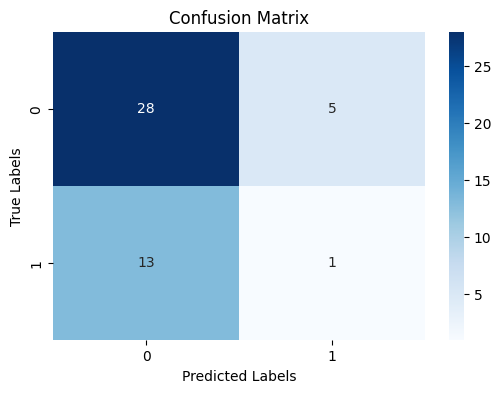

Confusion Matrix:
[[28  5]
 [13  1]]


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Threshold the predictions using the Thresholding function with threshold 0.5
threshold = 0.5
pred = model.predict([audio_test_tf, video_test_tf, text_test_tf])

thresholded_pred = Thresholding(pred, threshold)

# Calculate the confusion matrix
cf_matrix = confusion_matrix(Ytest, thresholded_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Print the raw confusion matrix
print("Confusion Matrix:")
print(cf_matrix)

In [42]:
# Print classification report
print("Classification Report:")
print(classification_report(Ytest, thresholded_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.85      0.76        33
         1.0       0.17      0.07      0.10        14

    accuracy                           0.62        47
   macro avg       0.42      0.46      0.43        47
weighted avg       0.53      0.62      0.56        47

